### EDA

In [2]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/Air-BnB-2-BW/data-science/master/airbnb_bw.csv'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

In [3]:
import pandas as pd

df = pd.read_csv(DATA_PATH, index_col=0)

print(df.shape)

df

(972, 13)


,Zipcode,Square Feet,Bedrooms,Bathrooms,Review Scores Rating,Accommodates,Cleaning Fee,Free Parking,Wireless Internet,Cable TV,Prop_encoded,cancel_encoded,Price
0,78704.0,500.0,1.0,1.0,97.0,2.0,25.0,1.0,1.0,1.0,1.0,2.0,85.0
22,78746.0,2800.0,4.0,2.5,99.0,8.0,300.0,1.0,1.0,1.0,1.0,2.0,499.0
108,78741.0,1600.0,1.0,1.5,100.0,4.0,100.0,1.0,1.0,1.0,1.0,0.0,450.0
109,78722.0,900.0,1.0,1.0,80.0,2.0,50.0,1.0,1.0,0.0,1.0,2.0,150.0
122,78702.0,2700.0,3.0,2.0,97.0,8.0,100.0,0.0,1.0,1.0,1.0,2.0,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
120258,78704.0,1810.0,3.0,2.0,93.0,6.0,180.0,1.0,1.0,1.0,1.0,0.0,499.0
120281,78704.0,2100.0,4.0,3.0,99.0,8.0,150.0,1.0,1.0,1.0,1.0,2.0,800.0
120466,78701.0,1094.0,2.0,1.5,100.0,6.0,100.0,0.0,1.0,1.0,1.0,2.0,899.0
120500,78722.0,600.0,1.0,1.0,98.0,2.0,69.0,1.0,1.0,0.0,1.0,2.0,79.0


In [ ]:
df['Bedrooms'].value_counts()

1.0    499
2.0    236
3.0    120
0.0     56
4.0     48
5.0      8
6.0      2
7.0      2
8.0      1
Name: Bedrooms, dtype: int64

In [ ]:
df['Zipcode'].value_counts()

78704.0    39
94110.0    25
94114.0    20
90291.0    20
78702.0    15
           ..
20005.0     1
60625.0     1
10013.0     1
20017.0     1
2108.0      1
Name: Zipcode, Length: 321, dtype: int64

In [ ]:
df['Price'].describe()

count    972.000000
mean     199.920782
std      158.690492
min       20.000000
25%       99.000000
50%      148.500000
75%      245.000000
max      995.000000
Name: Price, dtype: float64

In [ ]:
df['Square Feet'].describe()

count      972.000000
mean       989.981481
std       1276.106074
min          0.000000
25%        400.000000
50%        800.000000
75%       1300.000000
max      32292.000000
Name: Square Feet, dtype: float64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 972 entries, 0 to 120781
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Zipcode               972 non-null    float64
 1   Square Feet           972 non-null    float64
 2   Bedrooms              972 non-null    float64
 3   Bathrooms             972 non-null    float64
 4   Review Scores Rating  972 non-null    float64
 5   Accommodates          972 non-null    float64
 6   Cleaning Fee          972 non-null    float64
 7   Free Parking          972 non-null    float64
 8   Wireless Internet     972 non-null    float64
 9   Cable TV              972 non-null    float64
 10  Prop_encoded          972 non-null    float64
 11  cancel_encoded        972 non-null    float64
 12  Price                 972 non-null    float64
dtypes: float64(13)
memory usage: 106.3 KB


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



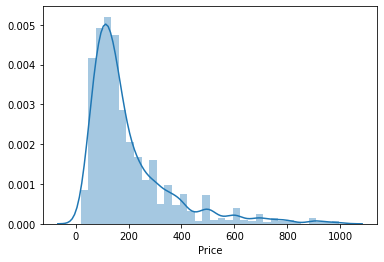

In [ ]:
# is the target symmetric - it is skewed right
%matplotlib inline
import seaborn as sns
sns.distplot(df['Price']);

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
df['Price'].describe()

count   972
mean    200
std     159
min      20
25%      99
50%     148
75%     245
max     995
Name: Price, dtype: float64

### Mean Baseline

In [ ]:
guess = df['Price'].mean()

In [ ]:
guess

199.92078189300412

In [ ]:
errors = guess - df['Price']

In [ ]:
errors

0         115
22       -299
108      -250
109        50
122       -75
         ... 
120258   -299
120281   -600
120466   -699
120500    121
120781    -60
Name: Price, Length: 972, dtype: float64

In [ ]:
mean_absolute_error = errors.abs().mean()

In [ ]:
print(f'If we just guessed every Airbnb cost ${guess:,.0f},')
print(f'we would be off by ${mean_absolute_error:,.0f} on average.')

If we just guessed every Airbnb cost $200,
we would be off by $113 on average.


### Set features / target

In [ ]:
from sklearn.model_selection import train_test_split
train, test= train_test_split(df, test_size=0.20)

# Arrange data into X features matrix and y target vector
features = ['Zipcode', 'Square Feet', 'Bedrooms', 'Bathrooms', 'Review Scores Rating', 'Accommodates', 'Cleaning Fee', 'Free Parking', 'Wireless Internet', 'Cable TV', 'Prop_encoded', 'cancel_encoded']
target = 'Price'
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [ ]:
row = X_train.iloc[[1]]
row

,Zipcode,Square Feet,Bedrooms,Bathrooms,Review Scores Rating,Accommodates,Cleaning Fee,Free Parking,Wireless Internet,Cable TV,Prop_encoded,cancel_encoded
69550,"78,704","1,000",2,1,95,5,20,1,1,0,1,0


In [ ]:
# What does the model predict for this Airbnb?
model.predict(row)

array([175.09469697])

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_pred_train = model.predict(X_train)
print("MAE(Train):$",mean_absolute_error(y_train, y_pred_train))

MAE(Train):$ 65.71765315411817


### Random Forest

In [ ]:
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.preprocessing import StandardScaler


In [ ]:
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    RandomForestRegressor(random_state=42)
)

param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1), 
}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    5.5s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   30.8s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   47.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   57.0s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:  1

In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'randomforestregressor__max_depth': 20, 'randomforestregressor__max_features': 0.35856215261376856, 'randomforestregressor__n_estimators': 264, 'simpleimputer__strategy': 'median', 'targetencoder__min_samples_leaf': 759}
Cross-validation MAE 61.84941498061594


### XGBoost

In [ ]:
from xgboost import XGBRegressor
pipeline = make_pipeline(
    ce.TargetEncoder(), 
    SimpleImputer(),
    StandardScaler(), 
    XGBRegressor(random_state=42,n_jobs=-1)
)
param_distributions = {
    'targetencoder__min_samples_leaf': randint(1, 1000),     
    'simpleimputer__strategy': ['mean', 'median'],
    'xgbregressor__learning_rate': [.03, 0.05, .07 ,0.13,0.2],
    'xgbregressor__max_depth': [5, 6, 7],}

# If you're on Colab, decrease n_iter & cv parameters
search = RandomizedSearchCV(
    pipeline, 
    param_distributions=param_distributions, 
    n_iter=100, 
    cv=10, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)
search.fit(X_train, y_train);

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    5.3s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   10.2s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

[19:29:24] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:  1.5min finished


In [ ]:
print('XG Boost MAE:', -search.best_score_)

XG Boost MAE: 60.51901280101125


### Permutation Importances

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=20, 
                           random_state=42, 
                           n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train);

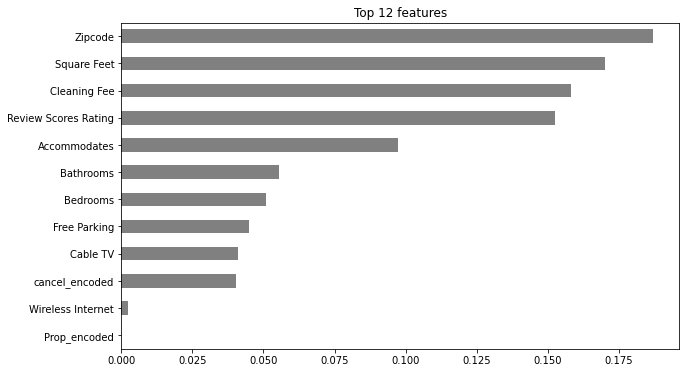

In [ ]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 12
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

### Partial Dependence Plot 1 feature

In [ ]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
print('Gradient Boosting R^2', r2_score(y_test, y_pred))

Gradient Boosting R^2 0.6500701507308941


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [ ]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Square Feet'

isolated = pdp_isolate(
      model=gb,
      dataset=X_test,
      model_features=X_test.columns,
      feature=feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1e57182b00>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f1e581d4d68>})

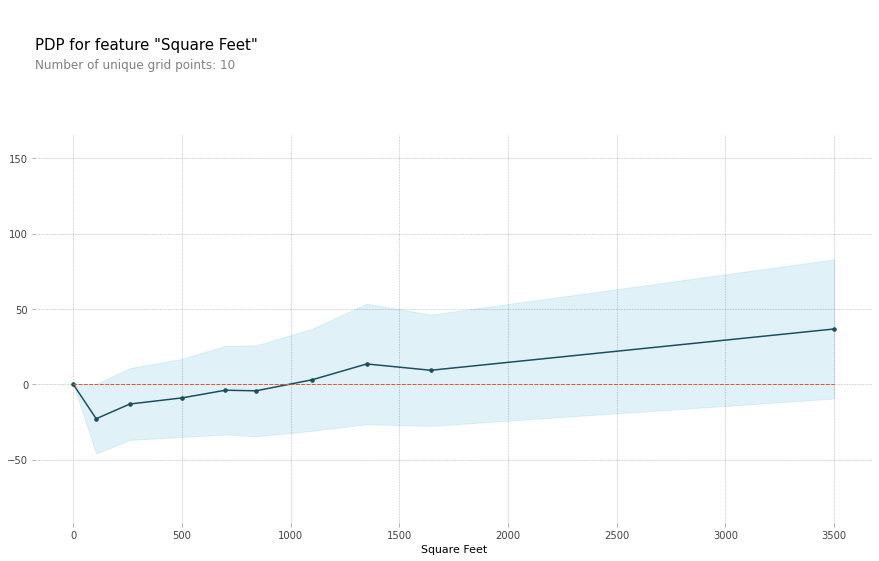

In [ ]:
pdp_plot(isolated, feature_name=feature)

### Partial Dependence Plot 2 features

In [ ]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Bedrooms', 'Bathrooms']

interaction = pdp_interact(
    model=gb,
    dataset=X_train,
    model_features=X_train.columns,
    features=features
)

In [ ]:
pdp_interact_plot

<function pdpbox.pdp.pdp_interact_plot>

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


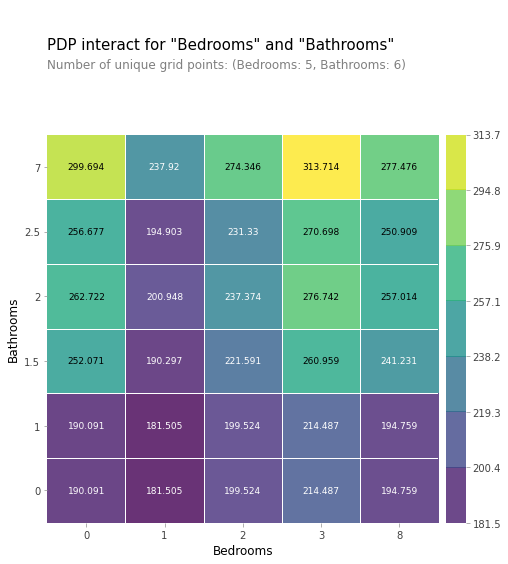

In [ ]:
pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

### Shapley Force Plot

In [ ]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestRegressor(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=5, 
    cv=2, 
    scoring='neg_mean_absolute_error', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=6, 
    random_state=42
)

search.fit(X_train, y_train);

Fitting 2 folds for each of 5 candidates, totalling 10 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done   3 out of  10 | elapsed:    4.8s remaining:   11.1s
[Parallel(n_jobs=6)]: Done   5 out of  10 | elapsed:    4.8s remaining:    4.8s
[Parallel(n_jobs=6)]: Done   7 out of  10 | elapsed:    6.3s remaining:    2.7s
[Parallel(n_jobs=6)]: Done  10 out of  10 | elapsed:    6.8s finished


In [ ]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', -search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.020584494295802447, 'n_estimators': 307}
Cross-validation MAE 64.75815459116487


In [ ]:
# Get an individual observation to explain.
# For example, the 5th row from the test set.
row = X_train.iloc[[5]]
row

,Zipcode,Square Feet,Bedrooms,Bathrooms,Review Scores Rating,Accommodates,Cleaning Fee,Free Parking,Wireless Internet,Cable TV,Prop_encoded,cancel_encoded
109897,"78,741","1,100",2,1,93,10,25,1,1,0,1,2


In [ ]:
# What was the actual price for this Airbnb?
y_test.iloc[[5]]

63137   395
Name: Price, dtype: float64

In [ ]:
# What does the model predict for this Airbnb?
model.predict(row)

array([171.08567292])

In [ ]:
# Look at a Shapley Values Force Plot
import shap

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(row)
shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)

### Visualizations

In [ ]:
(df['cost_per_person'] > 0).value_counts()

True    972
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 25).value_counts()

True     945
False     27
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 50).value_counts()

True     673
False    299
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 75).value_counts()

False    624
True     348
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 100).value_counts()

False    788
True     184
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 125).value_counts()

False    881
True      91
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 150).value_counts()

False    926
True      46
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 175).value_counts()

False    948
True      24
Name: cost_per_person, dtype: int64

In [ ]:
(df['cost_per_person'] > 200).value_counts()

False    959
True      13
Name: cost_per_person, dtype: int64

In [ ]:
# Engineer new feature to show cost per person
df['cost_per_person'] = ((df['Price'] + df['Cleaning Fee'])/(df['Accommodates'])).round(1)
df

In [7]:
import plotly.graph_objects as go

x = ['$0-25', '$25-50', '$50-75', '$75-100', '$100-125', '$125-150', '$150-175', '$175-200', '$200+']
y = [27, 272, 325, 125, 164, 93, 45, 22 ,13]

fig = go.Figure(data=[go.Bar(x=x, y=y)])


# Customize aspect
fig.update_traces(marker_color='rgb(158,202,225)', marker_line_color='rgb(8,48,107)',
                  marker_line_width=4.5, opacity=0.6)

fig.update_layout(title_text='Cost Per Person')
fig.show()

In [ ]:
!pip install chart_studio
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
username = 'egrinalds'
api_key = 'He4VCYKR4ZCWoyEYJQbh'
chart_studio.tools.set_credentials_file(username=username, api_key=api_key)
py.plot(fig, filename = 'Cost Per Person Analysis', auto_open=True)

'https://plotly.com/~egrinalds/36/'